# Zadanie
Wygląda na to, że nasze firmy kurierskie czasami nie radzą sobie z dostawami. Gdybyśmy wiedzieli, ile taka dostawa dla danego zamówienia potrwa – moglibyśmy przekazywać tą informację klientom.

# Problem biznesowy
Predykcja czasu dostawy, na podstawie informacji o zamówieniu

# Problem modelowania
Regresja

# Kryterium sukcesu


# Założenia
- wszystkie produky które zamawiają klienci są dostępne w churtowni
- dostawy odbywają się tylko w Polsce
- firma działa od poniedziałku do piątku, między godzinami 8-18 (zamówienia po 18 są realizowane dopiero następnego dnia)
- na czas transporu paczki nie wpływa miejsce churtowni
- produkty sprzedawane przez sklep nie wymagają specjalnego typu transportu (np przedmiot ma duży ciężar albo wymaga odpowiedniej temperatury przewozu)
- wszystkie przsyłki wysyłane tym samym kurierem mają taki sam priorytet (nie ma specjalnych wysyłek ekspresowych)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set()

In [3]:
deliveries = pd.read_json("../data/deliveries.jsonl", lines=True)
products = pd.read_json("../data/products.jsonl", lines=True)
sessions = pd.read_json("../data/sessions.jsonl", lines=True)
users = pd.read_json("../data/users.jsonl", lines=True)

# Tabela `deliveries`

In [4]:
deliveries["purchase_timestamp"] = pd.to_datetime(deliveries["purchase_timestamp"])
deliveries["delivery_timestamp"] = pd.to_datetime(deliveries["delivery_timestamp"])

In [5]:
deliveries

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-01-24 20:02:58,2021-01-26 00:30:29.368742,620.0
1,20002,2021-01-06 23:21:24,2021-01-06 01:29:32.083389,516.0
2,20003,2021-01-23 11:43:51,2021-01-23 09:44:31.822244,360.0
3,20004,2021-01-25 02:28:31,2021-01-28 23:52:57.166791,516.0
4,20005,2021-01-19 11:04:49,NaT,620.0
...,...,...,...,...
6885,26886,2021-01-07 07:36:39,2021-01-07 04:43:15.422456,360.0
6886,26887,2021-02-23 23:32:16,2021-02-26 00:36:17.992452,516.0
6887,26888,2021-02-27 10:35:43,2021-03-01 13:33:51.588772,620.0
6888,26889,2021-01-28 10:22:54,2021-01-31 23:18:29.703033,360.0


In [6]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6890 entries, 0 to 6889
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   purchase_id         6890 non-null   int64         
 1   purchase_timestamp  6890 non-null   datetime64[ns]
 2   delivery_timestamp  6568 non-null   datetime64[ns]
 3   delivery_company    6538 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 215.4 KB


## purchase_timestamp, delivery_timestamp

Kolumna `purchase_id` jest kluczem głównym. Kolumny `purchase_timestamp` i `delivery_timestamp` to odpowiednio chwila sprzedaży i dostawy zamówienia. Chwila dostawy może być pusta, np. gdy zamówienie jest w drodze do klienta, anulowano zamówienie, itd. Kolumna `delivery_company` to identyfikator firmy odpowiedzialnej za dostawę, może być pusty.

In [7]:
deliveries["purchase_timestamp"].min()

Timestamp('2021-01-01 00:07:14')

In [8]:
deliveries["purchase_timestamp"].max()

Timestamp('2021-03-15 07:58:22')

<AxesSubplot:>

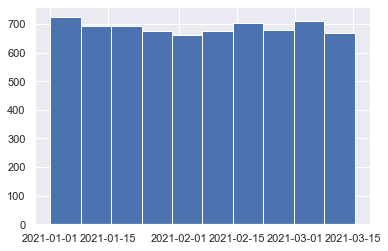

In [9]:
deliveries["purchase_timestamp"].hist()

Kolumna `purchase_timestamp` ma zakres wartości od `2021-01-01` do `2021-03-15` o rozkładzie jednostajnym.

In [10]:
deliveries["delivery_timestamp"].min()

Timestamp('2020-12-28 13:50:46.789583')

In [11]:
deliveries["delivery_timestamp"].max()

Timestamp('2021-03-21 00:38:39.205756')

<AxesSubplot:>

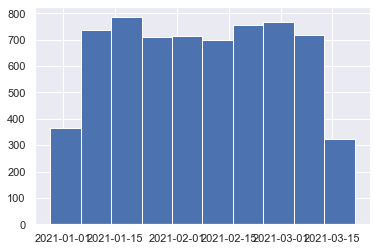

In [12]:
deliveries["delivery_timestamp"].hist()

⚠️ Warning: Dane o dostawach pochodzą tylko z trzech miesięcy. Istnieje ryzyko, że czasy dostawy znacznie będą się różnić w innych miesiącach, np. w okresie świątecznym.

In [13]:
deliveries[deliveries["purchase_timestamp"] > deliveries["delivery_timestamp"]]

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
1,20002,2021-01-06 23:21:24,2021-01-06 01:29:32.083389,516.0
2,20003,2021-01-23 11:43:51,2021-01-23 09:44:31.822244,360.0
6,20007,2021-01-16 21:38:04,2021-01-12 20:33:08.646922,360.0
8,20009,2021-02-22 06:09:39,2021-02-20 21:03:18.673649,620.0
9,20010,2021-01-28 05:10:38,2021-01-27 01:53:40.728429,620.0
...,...,...,...,...
6876,26877,2021-02-08 02:51:39,2021-02-04 04:23:51.523515,620.0
6878,26879,2021-02-28 08:43:52,2021-02-26 05:51:29.003432,620.0
6879,26880,2021-02-26 11:25:49,2021-02-25 00:50:23.176778,516.0
6885,26886,2021-01-07 07:36:39,2021-01-07 04:43:15.422456,360.0


Kolumna `delivery_timestamp` ma zakres wartości od `2020-12-28` do `2021-03-21` o przybliżonym rozkładzie jednostajnym. Podejrzane jest to, że dużo wartości jest mniejszych niż `purchase_timestamp` (ok. 30% danych).

In [14]:
deliveries["hours"] = (deliveries["delivery_timestamp"] - deliveries["purchase_timestamp"]).dt.total_seconds() / 3600

Możemy stworzyć nową kolumnę czasu dostawy `hours` będącą różnicą `delivery_timestamp` i `purchase_timestamp` wyrażoną w godzinach. Czas dostawy jest rozkładem normalnym $\mu=24.2$, $\sigma=47.4$.

In [15]:
deliveries["hours"].min()

-145.25644821361112

In [16]:
deliveries["hours"].max()

211.68822097

In [17]:
deliveries["hours"].mean()

24.20284636724477

In [18]:
deliveries["hours"].std()

47.417679139502866

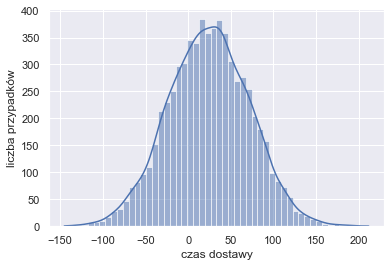

In [19]:
ax = sns.histplot(deliveries["hours"], kde=True)
ax.set(xlabel="czas dostawy", ylabel="liczba przypadków")
plt.show()

☠️ Error: Dane ewidentnie nie są poprawne. Ich ilość nie pozwala nam sądzić że jest to zwykły przypadkowy błąd. Dalsza dogłębniejsza analiza czasów nie ma sensu.

## delivery_company

In [20]:
sorted(deliveries["delivery_company"].unique())

[360.0, 516.0, 620.0, nan]

Kolumna `delivery_company` tak naprawdę jest typem dyskretnym o trzech możliwych niepustych wartościach. Może zostać zakodowana metodą *one-hot*.

# Tabela `products`

In [21]:
products

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,5.897000e+01
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2.048500e+09
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7.639000e+03
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,4.999000e+01
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,4.999000e+01
...,...,...,...,...
314,1315,Jabra Talk,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,5.499000e+01
315,1316,Plantronics Voyager Legend,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,2.490000e+02
316,1317,Plantronics Savi W740,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,-1.303960e+03
317,1318,Plantronics Savi W710,Sprzęt RTV;Audio;Słuchawki,-5.530000e+02


In [22]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     319 non-null    int64  
 1   product_name   319 non-null    object 
 2   category_path  319 non-null    object 
 3   price          319 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 10.1+ KB


Kolumna `product_id` jest kluczem głównym. Kolumna `product_name` jest nazwą produktu, można zakodować metodą *word embeddings*. Kolumna `category_path` jest hierarchią kategorii, do których należy produkt, można zakodować metodą *one-hot*.

In [23]:
categories = set()

for x in products["category_path"]:
    categories.update(x.lower().split(";"))

sorted(categories)

['akcesoria telefoniczne',
 'anteny rtv',
 'audio',
 'biurowe urządzenia wielofunkcyjne',
 'drukarki i skanery',
 'gry i konsole',
 'gry komputerowe',
 'gry na konsole',
 'gry playstation3',
 'gry xbox 360',
 'komputery',
 'monitory',
 'monitory lcd',
 'odtwarzacze dvd',
 'odtwarzacze mp3 i mp4',
 'okulary 3d',
 'przenośne audio i video',
 'sprzęt rtv',
 'słuchawki',
 'tablety',
 'tablety i akcesoria',
 'telefony i akcesoria',
 'telefony komórkowe',
 'telefony stacjonarne',
 'telewizory i akcesoria',
 'video',
 'zestawy głośnomówiące',
 'zestawy słuchawkowe']

Kolumna `price` jest ceną produktu.

In [24]:
products["price"].min()

-1303.96

In [25]:
products["price"].max()

5259000000.0

In [26]:
products["price"].mean()

35609195.75752351

In [27]:
products["price"].std()

341043170.2423

In [28]:
products[products["price"] > 1e4]

,product_id,product_name,category_path,price
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2.048500e+09
16,1017,LCD Dell U2412M,Komputery;Monitory;Monitory LCD,3.990000e+08
27,1028,Sniper Ghost Warrior 2 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,3.900000e+07
34,1035,Samsung Galaxy S III GT-i9300,Telefony i akcesoria;Telefony komórkowe,2.199900e+09
35,1036,LCD Asus VK228H,Komputery;Monitory;Monitory LCD,6.390000e+08
38,1039,LCD Asus VS197D,Komputery;Monitory;Monitory LCD,2.690000e+08
44,1045,Call of Duty Modern Warfare 2 (PS3),Gry i konsole;Gry na konsole;Gry PlayStation3,5.990000e+07
80,1081,OKI B840dn,Komputery;Drukarki i skanery;Biurowe urządzeni...,5.259000e+09
163,1164,Aliens Colonial Marines (PC),Gry i konsole;Gry komputerowe,1.129900e+08
190,1191,Red Faction Guerrilla (PC),Gry i konsole;Gry komputerowe,1.999000e+07


In [29]:
products[products["price"] <= 0]

,product_id,product_name,category_path,price
142,1143,GTR Evolution (PC),Gry i konsole;Gry komputerowe,-25.49
148,1149,Medal of Honor Warfighter (PC),Gry i konsole;Gry komputerowe,-56.90
235,1236,Avencast Rise of the Mage (PC),Gry i konsole;Gry komputerowe,-31.99
243,1244,Hard Reset (PC),Gry i konsole;Gry komputerowe,-9.99
274,1275,Rome Total War (PC),Gry i konsole;Gry komputerowe,-54.90
284,1285,Opticum AX-800,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,-82.99
316,1317,Plantronics Savi W740,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,-1303.96
317,1318,Plantronics Savi W710,Sprzęt RTV;Audio;Słuchawki,-553.00


⚠️ Warning: Niektóre produkty mają absurdalnie wysoką ($>10^6$) lub ujemną cenę.

# Tabela `sessions`

In [30]:
sessions

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,100001,2021-01-24 20:00:43,102.0,1001.0,VIEW_PRODUCT,0,NaN
1,100001,2021-01-24 20:02:58,102.0,1001.0,BUY_PRODUCT,0,20001.0
2,100002,2021-01-06 23:01:07,102.0,1038.0,VIEW_PRODUCT,0,NaN
3,100002,2021-01-06 23:05:01,102.0,1036.0,VIEW_PRODUCT,0,NaN
4,100002,2021-01-06 23:09:38,102.0,1033.0,VIEW_PRODUCT,0,NaN
...,...,...,...,...,...,...,...
37677,109836,2021-01-28 10:19:43,301.0,1317.0,VIEW_PRODUCT,0,NaN
37678,109836,2021-01-28 10:22:54,301.0,1317.0,BUY_PRODUCT,0,26889.0
37679,109837,2021-01-20 23:29:26,301.0,1074.0,VIEW_PRODUCT,5,NaN
37680,109837,2021-01-20 23:29:43,301.0,1072.0,VIEW_PRODUCT,5,NaN


In [31]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37682 entries, 0 to 37681
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   session_id        37682 non-null  int64         
 1   timestamp         37682 non-null  datetime64[ns]
 2   user_id           35794 non-null  float64       
 3   product_id        35797 non-null  float64       
 4   event_type        37682 non-null  object        
 5   offered_discount  37682 non-null  int64         
 6   purchase_id       6890 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 2.0+ MB


Kolumna `session_id` jest kluczem głównym. Kolumny `user_id`, `product_id`, `purchase_id` są kluczami obcymi. Klucze obce mogą być puste, gdyż może być sesja anonimowa, brak zakupu, brak danych o produkcie. Kolumna `timestamp` jest chwilą wystąpienia zdarzenia typu `event_type`. Kolumna `offered_discount` to oferowana przecena, w przypadku podjęcia zakupu.

In [32]:
sessions["event_type"].unique()

array(['VIEW_PRODUCT', 'BUY_PRODUCT'], dtype=object)

<AxesSubplot:>

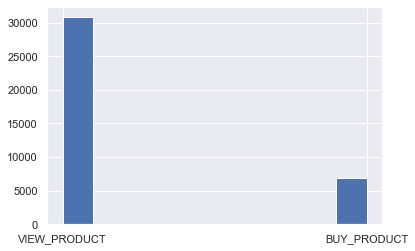

In [33]:
sessions["event_type"].hist()

Sesje składają się z dwóch możliwych zdarzeń: przeglądania i zakupu.

In [34]:
sessions["timestamp"].min()

Timestamp('2021-01-01 00:01:22')

In [35]:
sessions["timestamp"].max()

Timestamp('2021-03-15 08:05:24')

<AxesSubplot:>

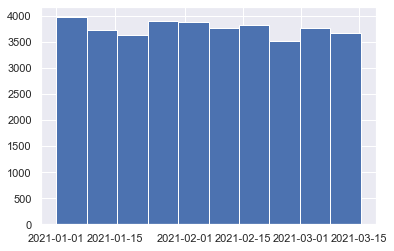

In [36]:
sessions["timestamp"].hist()

Kolumna `timestamp` ma zakres wartości od `2021-01-01` do `2021-03-15` o przybliżonym rozkładzie jednostajnym.

<AxesSubplot:>

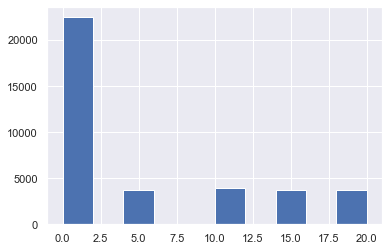

In [37]:
sessions["offered_discount"].hist()

In [38]:
sorted(sessions["offered_discount"].unique())

[0, 5, 10, 15, 20]

In [39]:
sessions.groupby("event_type").agg({"offered_discount": set})

,offered_discount
event_type,
BUY_PRODUCT,"{0, 5, 10, 15, 20}"
VIEW_PRODUCT,"{0, 5, 10, 15, 20}"


Zniżki są wielokrotnościami $5\%$, występują zarówno podczas przeglądania, jak i podczas zamawiania z podobną częstością. Najczęściej nie ma zniżki.

<AxesSubplot:>

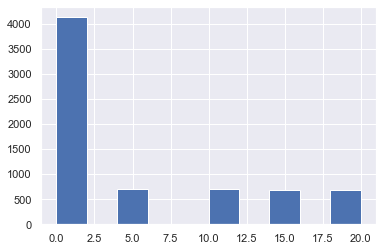

In [40]:
sessions[sessions["event_type"] == "BUY_PRODUCT"]["offered_discount"].hist()

<AxesSubplot:>

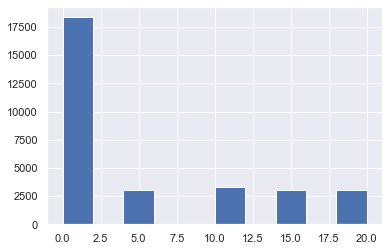

In [41]:
sessions[sessions["event_type"] == "VIEW_PRODUCT"]["offered_discount"].hist()

# Tabela `users`

In [42]:
users

,user_id,name,city,street
0,102,Albert Bruzda,Konin,plac Lwowska 683
1,103,Jędrzej Malesza,Mielec,plac Dąbrowskiego 81
2,104,Tymon Roszkiewicz,Mielec,pl. Matejki 942
3,105,Antoni Musiolik,Szczecin,ulica Jana III Sobieskiego 197
4,106,Rafał Gęgotek,Radom,ul. Gołębia 364
...,...,...,...,...
195,297,Anita Wabik,Warszawa,pl. Wspólna 421
196,298,Oliwier Szajda,Mielec,aleja Rejtana 36
197,299,Hubert Gogol,Konin,plac Diamentowa 328
198,300,Lidia Dobroń,Szczecin,al. Prusa 417


In [43]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  200 non-null    int64 
 1   name     200 non-null    object
 2   city     200 non-null    object
 3   street   200 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.4+ KB


Kolumna `user_id` jest kluczem głównym. Kolumna `name` zawiera imię, druge imię, nazwisko. Kolumna `city` jest miastem. Kolumna `street` jest ulicą oraz numerem domu.

In [44]:
users["name"].apply(lambda x: len(x.split(" "))).unique()

array([2, 3])

In [45]:
sorted(users["city"].unique())

['Gdynia',
 'Konin',
 'Kutno',
 'Mielec',
 'Police',
 'Radom',
 'Szczecin',
 'Warszawa']

In [46]:
sorted(users["street"].apply(lambda x: len(x.split(" "))).unique())

[3, 4, 5]

In [47]:
sorted(users["street"].apply(lambda x: x.split(" ")[0]).unique())

['al.', 'aleja', 'pl.', 'plac', 'ul.', 'ulica']

# Złączenie tabel

In [48]:
temp = sessions.merge(users, on="user_id", how="outer").merge(products, on="product_id", how="outer").merge(deliveries, on="purchase_id", how="outer")
temp

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,name,city,street,product_name,category_path,price,purchase_timestamp,delivery_timestamp,delivery_company,hours
0,100001.0,2021-01-24 20:00:43,102.0,1001.0,VIEW_PRODUCT,0.0,NaN,Albert Bruzda,Konin,plac Lwowska 683,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,NaT,NaT,NaN,NaN
1,100013.0,2021-01-28 05:09:39,102.0,1001.0,VIEW_PRODUCT,0.0,NaN,Albert Bruzda,Konin,plac Lwowska 683,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,NaT,NaT,NaN,NaN
2,100015.0,2021-01-19 12:50:49,102.0,1001.0,VIEW_PRODUCT,0.0,NaN,Albert Bruzda,Konin,plac Lwowska 683,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,NaT,NaT,NaN,NaN
3,100036.0,2021-03-09 23:01:57,102.0,1001.0,VIEW_PRODUCT,15.0,NaN,Albert Bruzda,Konin,plac Lwowska 683,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,NaT,NaT,NaN,NaN
4,100064.0,2021-01-06 23:18:35,102.0,1001.0,VIEW_PRODUCT,0.0,NaN,Albert Bruzda,Konin,plac Lwowska 683,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,NaT,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37918,108891.0,2021-02-16 23:16:23,282.0,1056.0,BUY_PRODUCT,5.0,26215.0,Patryk Myszor,Gdynia,aleja Skośna 62,Call of Duty Black Ops (PC),Gry i konsole;Gry komputerowe,29.99,2021-02-16 23:16:23,2021-02-16 12:41:07.157024,516.0,-10.587734
37919,109068.0,2021-01-02 01:57:34,285.0,1056.0,BUY_PRODUCT,0.0,26333.0,Nicole Kwapień,Szczecin,ulica Łąkowa 270,Call of Duty Black Ops (PC),Gry i konsole;Gry komputerowe,29.99,2021-01-02 01:57:34,2020-12-31 08:47:14.237715,620.0,-41.172156
37920,109105.0,2021-01-06 16:03:32,286.0,1056.0,BUY_PRODUCT,0.0,26356.0,Tomasz Nagel,Radom,al. Powstańców Śląskich 31/08,Call of Duty Black Ops (PC),Gry i konsole;Gry komputerowe,29.99,2021-01-06 16:03:32,2021-01-05 13:37:37.192347,620.0,-26.431891
37921,109384.0,2021-02-16 15:43:12,292.0,1056.0,BUY_PRODUCT,10.0,26579.0,Julita Buza,Gdynia,al. Szmaragdowa 446,Call of Duty Black Ops (PC),Gry i konsole;Gry komputerowe,29.99,2021-02-16 15:43:12,2021-02-20 17:42:55.693973,360.0,97.995471


In [49]:
Informacje które zostały nam dostarczone dają nam spore i

SyntaxError: invalid syntax (<ipython-input-49-71541dea9719>, line 1)

In [49]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37923 entries, 0 to 37922
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   session_id          37682 non-null  float64       
 1   timestamp           37682 non-null  datetime64[ns]
 2   user_id             35794 non-null  float64       
 3   product_id          36038 non-null  float64       
 4   event_type          37682 non-null  object        
 5   offered_discount    37682 non-null  float64       
 6   purchase_id         6890 non-null   float64       
 7   name                35794 non-null  object        
 8   city                35794 non-null  object        
 9   street              35794 non-null  object        
 10  product_name        36038 non-null  object        
 11  category_path       36038 non-null  object        
 12  price               36038 non-null  float64       
 13  purchase_timestamp  6890 non-null   datetime64

In [50]:
temp1 = temp[temp["event_type"] == "BUY_PRODUCT"]

In [56]:
temp1.loc[(temp1["price"] <= 0) | (temp1["price"] > 1e4) | (temp1["hours"] <= 0)]

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,name,city,street,product_name,category_path,price,purchase_timestamp,delivery_timestamp,delivery_company,hours
31034,100013.0,2021-01-28 05:10:38,102.0,1001.0,BUY_PRODUCT,0.0,20010.0,Albert Bruzda,Konin,plac Lwowska 683,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,2021-01-28 05:10:38,2021-01-27 01:53:40.728429,620.0,-27.282575
31036,100036.0,2021-03-09 23:03:20,102.0,1001.0,BUY_PRODUCT,15.0,20027.0,Albert Bruzda,Konin,plac Lwowska 683,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,2021-03-09 23:03:20,2021-03-06 23:08:33.548176,516.0,-71.912903
31037,100046.0,2021-01-10 15:52:16,102.0,1001.0,BUY_PRODUCT,0.0,20035.0,Albert Bruzda,Konin,plac Lwowska 683,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,2021-01-10 15:52:16,2021-01-09 16:00:16.211341,360.0,-23.866608
31044,103368.0,2021-02-17 18:50:54,NaN,1001.0,BUY_PRODUCT,0.0,22340.0,NaN,NaN,NaN,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,2021-02-17 18:50:54,2021-02-16 15:43:51.476820,620.0,-27.117368
31048,105874.0,2021-02-08 14:21:54,NaN,1001.0,BUY_PRODUCT,20.0,24100.0,NaN,NaN,NaN,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,2021-02-08 14:21:54,2021-02-06 15:17:55.338336,516.0,-47.066295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37916,108769.0,2021-02-22 11:10:27,280.0,1056.0,BUY_PRODUCT,20.0,26131.0,Ida Pasiak,Gdynia,plac Browarna 59,Call of Duty Black Ops (PC),Gry i konsole;Gry komputerowe,29.99,2021-02-22 11:10:27,2021-02-22 07:32:55.391913,516.0,-3.625447
37917,108870.0,2021-02-27 02:03:10,282.0,1056.0,BUY_PRODUCT,0.0,26199.0,Patryk Myszor,Gdynia,aleja Skośna 62,Call of Duty Black Ops (PC),Gry i konsole;Gry komputerowe,29.99,2021-02-27 02:03:10,2021-02-26 02:40:16.514009,NaN,-23.381524
37918,108891.0,2021-02-16 23:16:23,282.0,1056.0,BUY_PRODUCT,5.0,26215.0,Patryk Myszor,Gdynia,aleja Skośna 62,Call of Duty Black Ops (PC),Gry i konsole;Gry komputerowe,29.99,2021-02-16 23:16:23,2021-02-16 12:41:07.157024,516.0,-10.587734
37919,109068.0,2021-01-02 01:57:34,285.0,1056.0,BUY_PRODUCT,0.0,26333.0,Nicole Kwapień,Szczecin,ulica Łąkowa 270,Call of Duty Black Ops (PC),Gry i konsole;Gry komputerowe,29.99,2021-01-02 01:57:34,2020-12-31 08:47:14.237715,620.0,-41.172156


In [52]:
2796 / len(temp1)

0.4058055152394775

Około 40% `deliveries` ma podejrzany czas dostawy lub cenę.

In [76]:
data = temp1.loc[(temp1["session_id"] != None) & (temp1["user_id"] != None) & (temp1["purchase_id"] != None)]
data

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,name,city,street,product_name,category_path,price,purchase_timestamp,delivery_timestamp,delivery_company,hours
31033,100001.0,2021-01-24 20:02:58,102.0,1001.0,BUY_PRODUCT,0.0,20001.0,Albert Bruzda,Konin,plac Lwowska 683,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,2021-01-24 20:02:58,2021-01-26 00:30:29.368742,620.0,28.458714
31034,100013.0,2021-01-28 05:10:38,102.0,1001.0,BUY_PRODUCT,0.0,20010.0,Albert Bruzda,Konin,plac Lwowska 683,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,2021-01-28 05:10:38,2021-01-27 01:53:40.728429,620.0,-27.282575
31035,100015.0,2021-01-19 12:53:55,102.0,1001.0,BUY_PRODUCT,0.0,20012.0,Albert Bruzda,Konin,plac Lwowska 683,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,2021-01-19 12:53:55,2021-01-22 23:57:42.253201,360.0,83.063126
31036,100036.0,2021-03-09 23:03:20,102.0,1001.0,BUY_PRODUCT,15.0,20027.0,Albert Bruzda,Konin,plac Lwowska 683,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,2021-03-09 23:03:20,2021-03-06 23:08:33.548176,516.0,-71.912903
31037,100046.0,2021-01-10 15:52:16,102.0,1001.0,BUY_PRODUCT,0.0,20035.0,Albert Bruzda,Konin,plac Lwowska 683,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,2021-01-10 15:52:16,2021-01-09 16:00:16.211341,360.0,-23.866608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37918,108891.0,2021-02-16 23:16:23,282.0,1056.0,BUY_PRODUCT,5.0,26215.0,Patryk Myszor,Gdynia,aleja Skośna 62,Call of Duty Black Ops (PC),Gry i konsole;Gry komputerowe,29.99,2021-02-16 23:16:23,2021-02-16 12:41:07.157024,516.0,-10.587734
37919,109068.0,2021-01-02 01:57:34,285.0,1056.0,BUY_PRODUCT,0.0,26333.0,Nicole Kwapień,Szczecin,ulica Łąkowa 270,Call of Duty Black Ops (PC),Gry i konsole;Gry komputerowe,29.99,2021-01-02 01:57:34,2020-12-31 08:47:14.237715,620.0,-41.172156
37920,109105.0,2021-01-06 16:03:32,286.0,1056.0,BUY_PRODUCT,0.0,26356.0,Tomasz Nagel,Radom,al. Powstańców Śląskich 31/08,Call of Duty Black Ops (PC),Gry i konsole;Gry komputerowe,29.99,2021-01-06 16:03:32,2021-01-05 13:37:37.192347,620.0,-26.431891
37921,109384.0,2021-02-16 15:43:12,292.0,1056.0,BUY_PRODUCT,10.0,26579.0,Julita Buza,Gdynia,al. Szmaragdowa 446,Call of Duty Black Ops (PC),Gry i konsole;Gry komputerowe,29.99,2021-02-16 15:43:12,2021-02-20 17:42:55.693973,360.0,97.995471


In [77]:
data.drop(["timestamp", "user_id", "name", "event_type", "session_id", "product_id", "offered_discount", "purchase_id", "product_name", "category_path", "price"], axis=1, inplace=True)
data

,city,street,purchase_timestamp,delivery_timestamp,delivery_company,hours
31033,Konin,plac Lwowska 683,2021-01-24 20:02:58,2021-01-26 00:30:29.368742,620.0,28.458714
31034,Konin,plac Lwowska 683,2021-01-28 05:10:38,2021-01-27 01:53:40.728429,620.0,-27.282575
31035,Konin,plac Lwowska 683,2021-01-19 12:53:55,2021-01-22 23:57:42.253201,360.0,83.063126
31036,Konin,plac Lwowska 683,2021-03-09 23:03:20,2021-03-06 23:08:33.548176,516.0,-71.912903
31037,Konin,plac Lwowska 683,2021-01-10 15:52:16,2021-01-09 16:00:16.211341,360.0,-23.866608
...,...,...,...,...,...,...
37918,Gdynia,aleja Skośna 62,2021-02-16 23:16:23,2021-02-16 12:41:07.157024,516.0,-10.587734
37919,Szczecin,ulica Łąkowa 270,2021-01-02 01:57:34,2020-12-31 08:47:14.237715,620.0,-41.172156
37920,Radom,al. Powstańców Śląskich 31/08,2021-01-06 16:03:32,2021-01-05 13:37:37.192347,620.0,-26.431891
37921,Gdynia,al. Szmaragdowa 446,2021-02-16 15:43:12,2021-02-20 17:42:55.693973,360.0,97.995471


Jeżeli chodzi o same dostarczone dane, to posiadają wystarczając informacje na temat zamówień. Mamy informacje dokąd i kiedy została wysłana paczka, jaką firmą kurierską, oraz kiedy została dostarczona.

# Podsumowując
Dostarczona struktura danych jest jak najbardziej wystarczająca (posiada najważniejsze informacje). Niestety mame duże uwagi co do samej jakości danych:
- duża ilość danych (~30%) ma niepoprawne czasy zakupu/dostawy (towary zostają dostarczone przed zamówieniem)
- ogarniczony zakres czasu informacji o dostawach (tylko 3 miesiące)
- część produktów ma nieporawne ceny (ujemne albo stanowczo za wysokie)
W celu dalszej pracy musimy dostać poprawne dane.
